## CORACLE Set-up and Evaluation

In [12]:
### Data Processing

## Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Helper imports
import numpy as np
import pandas as pd
import os
import sys

from functools import reduce
import matplotlib.pyplot as plt

%matplotlib inline

current_working_dir = os.getcwd()
print(f"Current Working Directory: {current_working_dir}")
project_root = os.path.dirname(current_working_dir)
modules_path = os.path.join(project_root, 'Modules')
if modules_path not in sys.path:
    sys.path.append(modules_path)
    print(f"Added to sys.path for custom modules: {modules_path}")

####################################################################
#### NYSE Daily Open-Close Returns
####################################################################
data_folder_path = os.path.join(project_root, 'Data')
data_file_name = "OPCL_20000103_20201231.csv"
data_file_path = os.path.join(data_folder_path, data_file_name) # So that we get to the file itself and not the folder it is in
returns_df = pd.read_csv(data_file_path) # Assumes file exists and is readable
returns_df.set_index('ticker', inplace=True)
returns_df.columns = pd.to_datetime(returns_df.columns.str.lstrip('X'), format='%Y%m%d').strftime('%Y-%m-%d')
returns_df_cleaned = returns_df.dropna().transpose() # Assumes dropna results in non-empty returns_df
returns_df_cleaned.index = pd.to_datetime(returns_df_cleaned.index)
returns_df_cleaned.index.name = 'date'
print("Data loaded and cleaned. Sample (first 5 rows/cols):")
print(returns_df_cleaned.iloc[0:5,0:5])
print(f"Shape of the cleaned data: {returns_df_cleaned.shape}")


Current Working Directory: c:\Users\james\ICAIF_25\Current_Code\Script
Data loaded and cleaned. Sample (first 5 rows/cols):
ticker            AA       ABM       ABT       ADI       ADM
date                                                        
2000-01-03 -0.013042 -0.009188 -0.007117 -0.036071  0.000000
2000-01-04  0.010043  0.012346 -0.012786 -0.044261  0.005277
2000-01-05  0.047628 -0.006192  0.011111  0.014493 -0.015915
2000-01-06 -0.011713  0.000000  0.032553 -0.027719  0.010695
2000-01-07 -0.016118  0.003091  0.028573  0.033654  0.005249
Shape of the cleaned data: (5279, 663)


### Confounding Data

In [13]:
####################################################################
#### Constructing the dataframe for the Confounding Variables
####################################################################

"""
Data Source: Federal Reserve Economic Data (FRED)

DFF -> Federal Funds Effective Rate
T5YIE -> 5-Year Breakeven Inflation Rate (only from 2003)
USEPUINDXD -> Economic Policy Uncertainty Index for United States; News-based, 7 days moving average
VIX -> CBOE Volatility Index (VIX)
DCOILWTICO -> West Texas Intermediate (WTI) Crude Oil Prices: Cushing, Oklahoma
DTWEXBGS -> Broad U.S. Dollar Index: Trade Weighted Exchange Rate Index for Major Currencies (only from 2006)
DTWEXEMEGS-> Broad U.S. Dollar Index: Trade Weighted Exchange Rate Index for Emerging Market Economies (only from 2006)

Other Potential Data Sources:
Gold Prices (Futures/Spot), etc.
"""

files = ["DFF_20000103_20201231.csv",
         "T5YIE_20030102_20201231.csv",
         "USEPUINDXD_20000103_20201231.csv",
         "VIX_20000103_20201231.csv",
         "DCOILWTICO_20000103_20201231.csv",
         "DTWEXBGS_20060102_20201231.csv",
         "DTWEXEMEGS_20060102_20201231.csv"
         ]


merged_confound_df = reduce(
    lambda left, right: pd.merge(left, right, on="observation_date", how="outer"),
    (pd.read_csv(os.path.join(data_folder_path, f), parse_dates=[0]) for f in files)
)
imputed_confound_df = merged_confound_df.interpolate(method='linear', limit_direction='both')
imputed_confound_df.set_index('observation_date', inplace=True)
imputed_confound_df.index.name = 'date'  # Renaming index to 'date'
print("Confounding Variables DataFrame constructed and cleaned. Sample (first 5 rows/cols):")
print(imputed_confound_df.iloc[0:5,:])
print(f"Shape of the cleaned confounding variables data: {imputed_confound_df.shape}")
filtered_confound_df = imputed_confound_df[imputed_confound_df.index.isin(returns_df_cleaned.index)]
print("\n")
print("Filtering by trading dates ...")
print("\n")
print("Filtered Confounding Variables DataFrame:")
print(filtered_confound_df.head())
print(f"Shape of the filtered confounding variables data: {filtered_confound_df.shape}")

Confounding Variables DataFrame constructed and cleaned. Sample (first 5 rows/cols):
             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2000-01-01  3.99    1.3       68.04   24.21       25.56  101.4155    100.9386
2000-01-02  3.99    1.3      119.36   24.21       25.56  101.4155    100.9386
2000-01-03  5.43    1.3       35.73   24.21       25.56  101.4155    100.9386
2000-01-04  5.38    1.3      109.31   27.01       25.56  101.4155    100.9386
2000-01-05  5.41    1.3      123.22   26.41       24.65  101.4155    100.9386
Shape of the cleaned confounding variables data: (7671, 7)


Filtering by trading dates ...


Filtered Confounding Variables DataFrame:
             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2000-01-03  5.43    1.3       35.73   24.21       25.56  101.4155    100.9386

## ORACLE-VAR

In [14]:
from DML_tools_copy import *

returns_df_cleaned_prep = returns_df_cleaned.iloc[-1020:]
filtered_confound_df_prep = filtered_confound_df.loc[returns_df_cleaned_prep.index]
print(filtered_confound_df_prep.head())
print(filtered_confound_df_prep.shape)

             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2016-12-12  0.41   1.86       99.45   12.64       52.74  116.9161    122.3953
2016-12-13  0.41   1.86      336.71   12.72       52.99  116.8029    122.3827
2016-12-14  0.41   1.82       53.87   13.19       51.01  116.7332    122.3870
2016-12-15  0.66   1.78      232.94   12.79       50.90  118.8072    123.7085
2016-12-16  0.66   1.75       53.13   12.20       51.93  118.3584    123.4953
(1020, 7)


In [15]:
returns_df_cleaned.iloc[-1,:]

ticker
AA     0.002172
ABM    0.005565
ABT    0.012129
ADI    0.008361
ADM    0.007367
         ...   
XLY    0.000435
XOM   -0.006047
XRX    0.017838
YUM   -0.001657
ZTR   -0.001138
Name: 2020-12-31 00:00:00, Length: 663, dtype: float64

In [ ]:
results = rolling_window_OR_VAR_w_para_search(whole_df = returns_df_cleaned_prep, confound_df = filtered_confound_df_prep,
                                              days_valid = 1)

It is day 1008 out of 1019 days in the dataset.
Validation errors for different p values: [(1, 0.015677165500829152), (2, 0.01371159682921207), (3, 0.01513768693302588), (4, 0.01569927893977562), (5, 0.014206460014381857)]
It is day 1009 out of 1019 days in the dataset.
Validation errors for different p values: [(1, 0.007704479236569565), (2, 0.004691346097982002), (3, 0.003565075156831928), (4, 0.0044937434450483095), (5, 0.0048328749018144235)]
It is day 1010 out of 1019 days in the dataset.
Validation errors for different p values: [(1, 0.011127256338231625), (2, 0.011772424052094312), (3, 0.010399155077850254), (4, 0.011164601106531905), (5, 0.011014691585059045)]
It is day 1011 out of 1019 days in the dataset.
Validation errors for different p values: [(1, 0.0048058440594188016), (2, 0.005576933723104667), (3, 0.005367071776265164), (4, 0.0070477249167185995), (5, 0.005471775443465792)]
It is day 1012 out of 1019 days in the dataset.
Validation errors for different p values: [(1, 

In [6]:
# import pickle

# # Save the dictionary
# #with open('result.pkl', 'wb') as f:
# #    pickle.dump(results, f)

# # Load the dictionary
# with open('result.pkl', 'rb') as f:
#     results = pickle.load(f)

In [7]:
## Using results, we will plot the overall PnL

# First, we compute the PnL for each day.
print(results)

{'test_start': 1008, 'num_days': 1019, 'p_optimal': array([3., 2., 5., 3., 1., 1., 3., 5., 3., 3., 1.]), 'Y_hat_next_store': array([[ 3.41e-03,  3.77e-03,  1.25e-02, -6.08e-03, -2.23e-03,  1.51e-02,
        -1.73e-03,  2.69e-03,  1.96e-03,  6.25e-03,  2.56e-03, -1.20e-03,
        -1.75e-03, -8.03e-03,  2.59e-03, -1.73e-02, -2.47e-03,  4.73e-04,
        -7.50e-03, -1.22e-02],
       [ 1.02e-03,  2.95e-03,  4.64e-03, -3.79e-04,  1.79e-03, -1.04e-03,
         2.04e-03,  7.83e-04,  2.56e-03,  1.19e-03, -1.47e-03,  6.38e-03,
        -1.18e-02,  1.40e-04,  3.41e-03,  1.31e-02, -6.47e-04, -1.95e-03,
        -2.08e-02,  3.43e-03],
       [ 3.06e-03,  8.02e-04,  2.63e-03,  2.06e-03,  3.52e-03,  8.71e-03,
        -5.51e-03,  2.34e-03, -1.95e-03,  4.81e-03,  2.21e-04, -2.02e-03,
         3.88e-03,  2.80e-03,  4.95e-04, -2.56e-03,  1.14e-03,  2.62e-03,
         8.44e-03, -9.24e-03],
       [ 2.93e-03,  4.41e-03,  4.23e-03,  6.32e-03, -4.52e-03,  3.51e-03,
        -5.07e-03,  2.58e-03, -2.62e-04,  

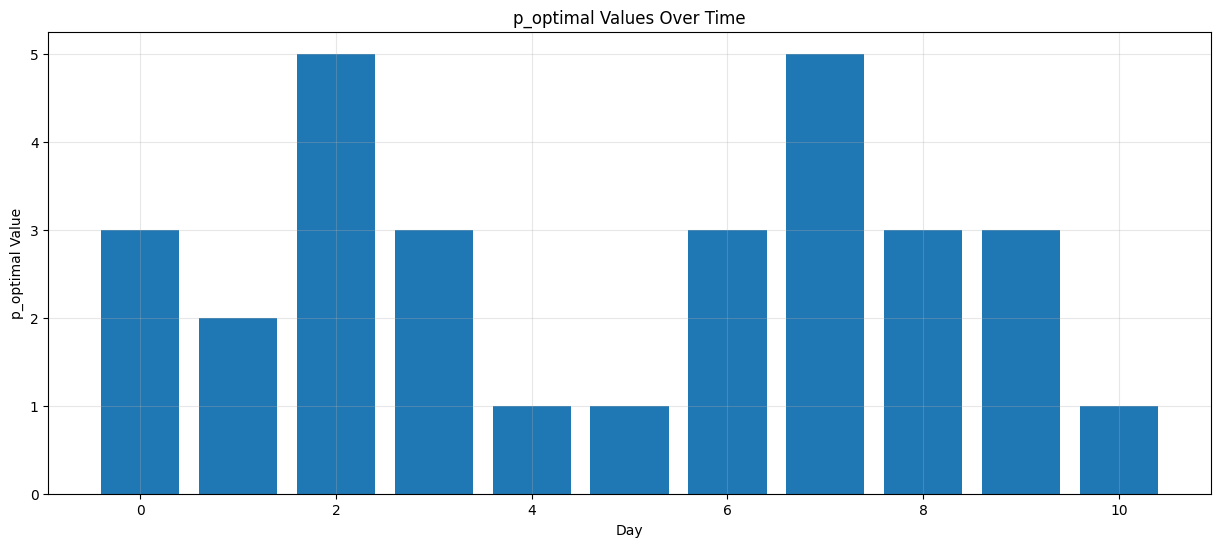

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract p_optimal from your results dictionary
p_optimal = results['p_optimal']
days = np.arange(len(p_optimal))

# Create the plot
plt.figure(figsize=(15, 6))
plt.bar(days, p_optimal)
plt.xlabel('Day')
plt.ylabel('p_optimal Value')
plt.title('p_optimal Values Over Time')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
from DML_tools import calculate_pnl
forecasted_returns = pd.DataFrame(results['Y_hat_next_store'],
                                  index=returns_df_cleaned_prep.index[-1020+252*4+1:])#,
                                #   columns=returns_df_cleaned_prep.columns)
actual_df = calculate_weighted_cluster_portfolio_returns(returns_df_cleaned_prep, 252*4, 20, 1)
actual_returns = actual_df.iloc[-1020+252*4+1:]
print(actual_returns.equals(forecasted_returns))
print(actual_returns.head())
print(forecasted_returns.head())
print(forecasted_returns.shape)
print(actual_returns.shape)

pnl_series_n = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="naive")
pnl_series_w = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="weighted")
pnl_series_t = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="top")
# print(pnl_series_n.head())

'''
Example
forecasted_returns = [[3,4],
                      [2,1],
                      [5,6]]
Each column is an asset, and each row is a day (prediction for next three days, for 2 assets)

actual_returns     = [[4,4],
                      [5,1],
                      [5,7]]

calculate_pnl returns a a series of PnL values for each day based on the strategy specified;

shape = [[1.04],
         [0.978],
         [1.01]]
    where each value is the PnL for that day based on the strategy (these are cumulative PnL)

'''

False
                  0         1         2         3         4         5   \
date                                                                     
2020-12-16 -0.000956 -0.003552 -0.015725 -0.000681 -0.015754  0.006073   
2020-12-17  0.002854 -0.001771  0.001618  0.000220  0.000084  0.004533   
2020-12-18 -0.000106 -0.009703 -0.012617 -0.004759 -0.005161  0.001002   
2020-12-21  0.000174  0.009615 -0.006729  0.009699 -0.007933  0.007011   
2020-12-22 -0.000853 -0.008850 -0.000303 -0.001949 -0.005622  0.004978   

                  6         7         8         9         10        11  \
date                                                                     
2020-12-16 -0.002984  0.000000 -0.000744 -0.016830  0.000205 -0.009009   
2020-12-17 -0.004603 -0.002167  0.004586 -0.004127  0.004421 -0.007737   
2020-12-18  0.003070 -0.002176 -0.002479 -0.006226  0.000890 -0.001285   
2020-12-21  0.001909 -0.008753 -0.002085  0.002776  0.004062  0.003216   
2020-12-22  0.000425  0.002191 

'\nExample\nforecasted_returns = [[3,4],\n                      [2,1],\n                      [5,6]]\nEach column is an asset, and each row is a day (prediction for next three days, for 2 assets)\n\nactual_returns     = [[4,4],\n                      [5,1],\n                      [5,7]]\n\ncalculate_pnl returns a a series of PnL values for each day based on the strategy specified;\n\nshape = [[1.04],\n         [0.978],\n         [1.01]]\n    where each value is the PnL for that day based on the strategy (these are cumulative PnL)\n\n'

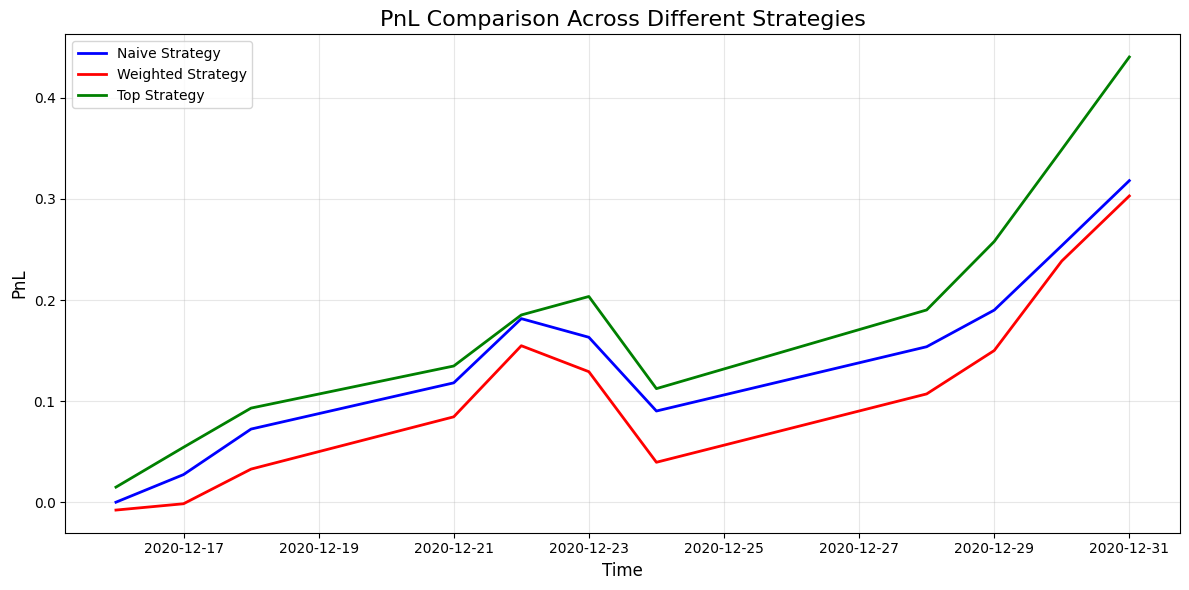

In [10]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(pnl_series_n, color='blue', label='Naive Strategy', linewidth=2)
plt.plot(pnl_series_w, color='red', label='Weighted Strategy', linewidth=2)
plt.plot(pnl_series_t, color='green', label='Top Strategy', linewidth=2)

# Customize the plot
plt.title('PnL Comparison Across Different Strategies', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('pnl_comparison.png')
plt.show()

In [11]:
import numpy as np

# One-liner function
def get_metrics(series):
    daily_rets = series.diff().dropna()
    ann_ret = series.iloc[-1] * (252 / len(series))
    sharpe = (daily_rets.mean() * 252) / (daily_rets.std() * np.sqrt(252))
    return ann_ret*100, sharpe

# Get metrics for all strategies
for name, series in [("Naive", pnl_series_n), ("Weighted", pnl_series_w), ("Top", pnl_series_t)]:
    ann_ret, sharpe = get_metrics(series)
    print(f"{name}: {ann_ret:.4f}% annualized, Sharpe: {sharpe:.4f}")

Naive: 728.3985% annualized, Sharpe: 11.2918
Weighted: 693.7429% annualized, Sharpe: 9.1311
Top: 1008.2944% annualized, Sharpe: 12.7717
